In [1]:
# Last test kernel before pretraining officially starts
# This one will consume both game snapshots and text

In [2]:
from visual_transformer import *
brain = DefaultAgentBrain().cuda()

In [3]:
# First, let's load the game deets

from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
game_settings = BIG_tool_use_advanced_2_5

In [5]:
game_settings.gameSize = 224 # for compatibility with brain's expected size

In [6]:
G = discreteGame(game_settings)

In [7]:
import matplotlib.pyplot as plt

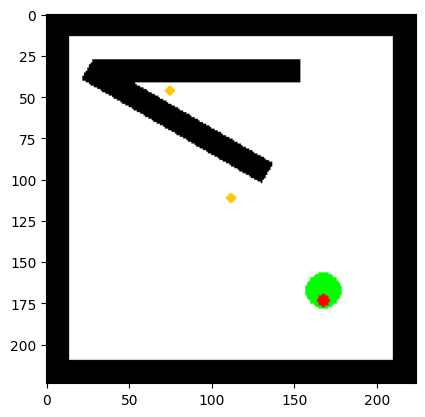

In [8]:
plt.imshow(G.getData())

In [9]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [10]:
# Ok, now let's laod the text data

In [11]:
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from torch.utils.data import Dataset

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
paths = ["text_pretraining_data/eng_sentences_pruned-train.txt"]
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

## Dataset
class SampleDataset(Dataset):
    def __init__(self, seq_length = 32, evaluate: bool = False, tokenizer=None, device = None):
        if device is None:
            device = 'cpu'
        self.device = device
        self.seq_length = seq_length
        if tokenizer is None:
            tokenizer = ByteLevelBPETokenizer(
                "./text_pretraining_tokenizer/eng_sentences_tokenizer_v2-vocab.json",
                "./text_pretraining_tokenizer/eng_sentences_tokenizer_v2-merges.txt",
            )   
        tokenizer._tokenizer.post_processor = BertProcessing(
            ("</s>", tokenizer.token_to_id("</s>")),
            ("<s>", tokenizer.token_to_id("<s>")),
        )   
        tokenizer.enable_truncation(max_length=self.seq_length)
        tokenizer.enable_padding()#length=seq_length)
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []

        src_files = Path("./text_pretraining_data/").glob("*-eval.txt") if evaluate else Path("./text_pretraining_data/").glob("*-train.txt")
        for src_file in src_files:
            print("🔥", src_file)
            lines = src_file.read_text(encoding="utf-8").splitlines()
            self.examples += [x.ids for x in tokenizer.encode_batch(lines)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i): 
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i]).to(self.device)

In [13]:
sdt = SampleDataset(tokenizer=tokenizer)
sdv = SampleDataset(tokenizer=tokenizer, evaluate=True)

🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


In [14]:
# Ok, now let's get both in a shape that can be consumed by brain

In [15]:
img_set = G.random_full_image_set(restrict_angles=True)

In [16]:
cutoff = 10 #16 # play with this

In [17]:
#img_tensor = torch.permute(torch.FloatTensor(img_set[:cutoff]).cuda(), (0, 3, 1, 2))

In [18]:
#text_tensor = sdt[:cutoff].cuda()

In [19]:
#text_probs, img_reconstruction = brain(text_tensor, img_tensor, ret_imgs = True)

In [20]:
# and only 5 gigs for 10 samples! Amazing
# I can push it up to 16 samples in inference, but I'm not going to push it.

In [21]:
#img_tensor = torch.permute(torch.FloatTensor(img_set[:cutoff]).cuda(), (0, 3, 1, 2))

In [22]:
#img_encoding = brain.img_enc(img_tensor)

In [23]:
#img_encoding.size()

In [24]:
multiplier = 12 #8 #4 #8 #16
text_batch_size = cutoff * multiplier

In [25]:
text_tensor = sdt[:text_batch_size].cuda()

In [26]:
src_attention_mask, src_key_padding_mask = brain.get_masks(text_tensor, use_masks=True)
text_encoding = brain.get_text_encoding(text_tensor, src_attention_mask, src_key_padding_mask)

In [27]:
#img_context = torch.cat([img_encoding for i in range(multiplier)], dim=0)
img_context = torch.randn((text_batch_size, 256, 768), device=text_tensor.device)

In [28]:
#img_recon = brain.img_dec(img_encoding, text_encoding[:cutoff])

In [29]:
text_probs = brain.get_text_decoding(text_encoding, src_attention_mask, src_key_padding_mask, img_context, return_full=True)

In [30]:
# a multiplier of 4 works (on 8 gigs). That's 40 sentences per batch.
32*4*2 / 40

6.4

In [31]:
0.4 * 60 + 6.4*8

75.2

In [32]:
# Plus 6 hours, that 7 hours per epoch.
7 * 16 / 24

4.666666666666667

In [33]:
# THis goes till Friday.
# I suppose this could be one way to force behavior. This runs while I fix the big server.
# But there simply must be a better way.

# Retrying with random activations and no image recon at all.

In [34]:
32*8

256

In [36]:
# Using random image contexts, I think I can get it down to 30-odd hours, using batch size of 120
# THis still locks in behavior, but not half as bad as before.
# So, pretraining the text context first, followed by image context later.
# Random inputs.
# Actually making the two talk to each other (and ignore each other) counts as finetuning (if it's needed)

In [1]:
5.5 * 16 / 24

3.6666666666666665

In [2]:
# It'll have to do.